## import packages

In [1]:
from Utils.Models import *
from Utils.Densenet import *
from ultralytics import YOLO
# 设置默认字体为黑体
plt.rcParams['font.family'] = ['WenQuanYi Zen Hei']  # 黑体
# 或者设置能够支持中文的其他字体名称
# plt.rcParams['font.family'] = ['SimSun']  # 宋体

# 对于负号显示问题，确保正常显示
plt.rcParams['axes.unicode_minus'] = False

2024-06-08 11:22:46.331569: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## 真实数据处理

In [7]:
newdata = np.loadtxt('/home/jiajianhao/文档/cnn/my_Magnetic_methods-master/mydata/new_data.txt')
newdata = newdata - 55100

In [8]:
def real_data_reship(data, x_length=25, y_length=25, new_size=512, map_lenght=25):
    """
    将数据重新调整成新的尺寸
    """
    zmax = data.shape[0]
    No_pad_left = int((zmax) - zmax/2)
    No_pad_right = int((zmax) + zmax/2)
    new_size_x = int(new_size/map_lenght*x_length)
    new_size_y = int(new_size/map_lenght*y_length)
    X_data = np.zeros((new_size_y, new_size_x))

    border_o = int((zmax)/2)

    # data变换大小
    img = data[:, :]
    X_data_padded = cv2.copyMakeBorder(
        img, border_o, border_o, border_o, border_o, 0)
    X_array_os = X_data_padded[No_pad_left:No_pad_right,
                               No_pad_left:No_pad_right]
    X_array_yolo = cv2.resize(
        X_array_os, (new_size_x, new_size_y), interpolation=cv2.INTER_CUBIC)
    X_data[:, :] = X_array_yolo

    return X_data

In [9]:
newdata= real_data_reship(newdata)

In [11]:
import cv2

def convert_to_yolo_realdata(X_data_array, name="read_data_yolo.jpg"):

    X_data_array_norm = (X_data_array - np.min(X_data_array)) / (
        np.max(X_data_array) - np.min(X_data_array))
    print(X_data_array_norm.shape)
    print(X_data_array_norm.mean())
    # 转rgb
    dataRGB = map_rgb(X_data_array_norm)
    print(dataRGB.shape)
    print(dataRGB.max())
    color_mapped_bgr = cv2.cvtColor(
        dataRGB, cv2.COLOR_RGB2BGR)

    cv2.imwrite(name, dataRGB)

In [12]:
convert_to_yolo_realdata(newdata)

(512, 512)
0.42245721384422236
(512, 512, 3)
255


## YOLO

### load model

In [2]:
yolo_model_dir = "/home/jiajianhao/文档/cnn/my_Magnetic_methods-master/YOLOv8/my_Model_training/runs/detect/4000data/weights/best.pt"
model = YOLO(yolo_model_dir)

### predict my data

In [3]:
yolo_prd_dir = "/home/jiajianhao/文档/cnn/my_Magnetic_methods-master/read_data_yolo.jpg"
yolo_results = model.predict(source=yolo_prd_dir, save=True, save_txt=True,iou=0.1)


image 1/1 /home/jiajianhao/文档/cnn/my_Magnetic_methods-master/read_data_yolo.jpg: 640x640 2 dipoles, 4 ellipsoids, 16.1ms
Speed: 28.4ms preprocess, 16.1ms inference, 3283.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict7
1 label saved to runs/detect/predict7/labels


In [4]:

def load_box(path):
    data = np.loadtxt(path)
    print(data)
    m, n = data.shape
    kind_of_data = np.zeros((1, 9)).astype(np.int32)
    kind_of_data[0,:5] = data.T[0]
    print(kind_of_data)
    kind, n_of_each = np.unique(data.T[0], return_counts=True)
    print(kind, n_of_each)

    box = data.T[1:]*50
    box[0] = box[0] - 25-box[2]/2
    box[1] = box[1] - 25-box[3]/2
    box = box.T

    parameter = np.zeros((1, 9))
    num_of_ano = []
    num_of_ano.append(m)
    bbox = np.zeros((1, m, 4))
    bbox[0] = box
    return parameter, num_of_ano, bbox, kind_of_data,n_of_each

In [5]:
parameter, num_of_dipoles, bbox,kind_of_data,n_of_each = load_box('/home/jiajianhao/文档/cnn/my_Magnetic_methods-master/runs/detect/predict5/labels/read_data_yolo.txt')

[[          1     0.77889     0.13747     0.10479    0.098774]
 [          1     0.93311      0.6849     0.10735     0.10237]
 [          1       0.835     0.41004     0.10963    0.061262]
 [          1     0.85372      0.7456    0.086671     0.09684]
 [          0     0.72531      0.1633     0.12189    0.090318]]
[[1 1 1 1 0 0 0 0 0]]
[          0           1] [1 4]


In [13]:
m,n = newdata.shape
data = np.zeros((1,m,n))
data[0] = newdata

In [14]:
newdata.max()

65.54200014869525

In [15]:
def cov_to_densenet(
        parameter, num_of_ano, bbox, datas,
        map_length=25, den_size=64):
    """
    输入:
        parameter: (data_num,nummax,n) n表示n个参数
        num_of_ano: (,data_num) 每个数据点有多少个磁异常
        bbox: (data_num,nummax,4) 每个数据点的边界,
        datas: (data_num,zmax,zmax) 所有磁异常图
        den_size: 输入到densenet的图像大小
    """
    NofD = parameter.shape[0] #1 
    NofK = parameter.shape[1] # 9
    zmax = datas.shape[-1]  # 64
    length = int(map_length*2)
    YOLO_box = np.copy(bbox)
    YOLO_box[:, :, 0] = YOLO_box[:, :, 0] + map_length
    YOLO_box[:, :, 1] = YOLO_box[:, :, 1] + map_length
    # YOLO_box变成索引
    YOLO_box = (YOLO_box/length*zmax).astype(np.uint16)
    index_den = np.zeros_like(YOLO_box, dtype=np.uint16)  # den中xy的索引
    index_den[:, :, 0] = (den_size - YOLO_box[:, :, 2])//2
    index_den[:, :, 1] = (den_size - YOLO_box[:, :, 3])//2
    index_den[:, :, 2] = YOLO_box[:, :, 2] + index_den[:, :, 0]
    index_den[:, :, 3] = YOLO_box[:, :, 3] + index_den[:, :, 1]

    YOLO_box[:, :, 2] = YOLO_box[:, :, 2] + YOLO_box[:, :, 0]
    YOLO_box[:, :, 3] = YOLO_box[:, :, 3] + YOLO_box[:, :, 1]

    all_densenet = np.zeros((NofD, NofK, den_size, den_size))
    for i in range(NofD):
        for j in range(num_of_ano[i]):
            x0, y0, x1, y1 = YOLO_box[i, j]
            x2, y2, x3, y3 = index_den[i, j]
            all_densenet[i, j, y2:y3, x2:x3] = datas[i, y0:y1, x0:x1]

    return all_densenet



In [16]:
den_data = cov_to_densenet(parameter, num_of_dipoles, bbox,data)
data,para = fliter_acdt_type(n_of_each, parameter, num_of_dipoles,den_data, kind_of_data)

In [17]:
den_data.max()

65.54200014869525

In [18]:
dipole_data,ellipse_data = data['0'],data['1']
dipole_para,ellipse_para = para['0'],para['1']

In [19]:
ellipse_data.shape

(4, 64, 64)

In [20]:
dipole_data_img = gray_to_rgb(dipole_data)
ellipse_data_img = gray_to_rgb(ellipse_data)

In [37]:
def plot_densenet_data(den_data, map_lenght=25/8):
    zmax = den_data.shape[-1]

    xmin = -map_lenght
    xmax = map_lenght
    ymin = -map_lenght
    ymax = map_lenght

    X = np.linspace(xmin, xmax, zmax)
    Y = np.linspace(ymin, ymax, zmax)

    # Adjust the size of your images
    plt.figure(figsize=(10, 8))

    # Iterate and plot random images 迭代 绘制随机图像
    for i in range(4):

        n_p = i

        plt.subplot(2, 2, i + 1)
        plt.contourf(X, Y, den_data[i, :, :], levels=40, cmap='rainbow')
        plt.axis('on')
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        clb = plt.colorbar()
        clb.set_label('(nT)',loc="top", rotation=360)

    # Adjust subplot parameters to give specified padding
    plt.tight_layout()

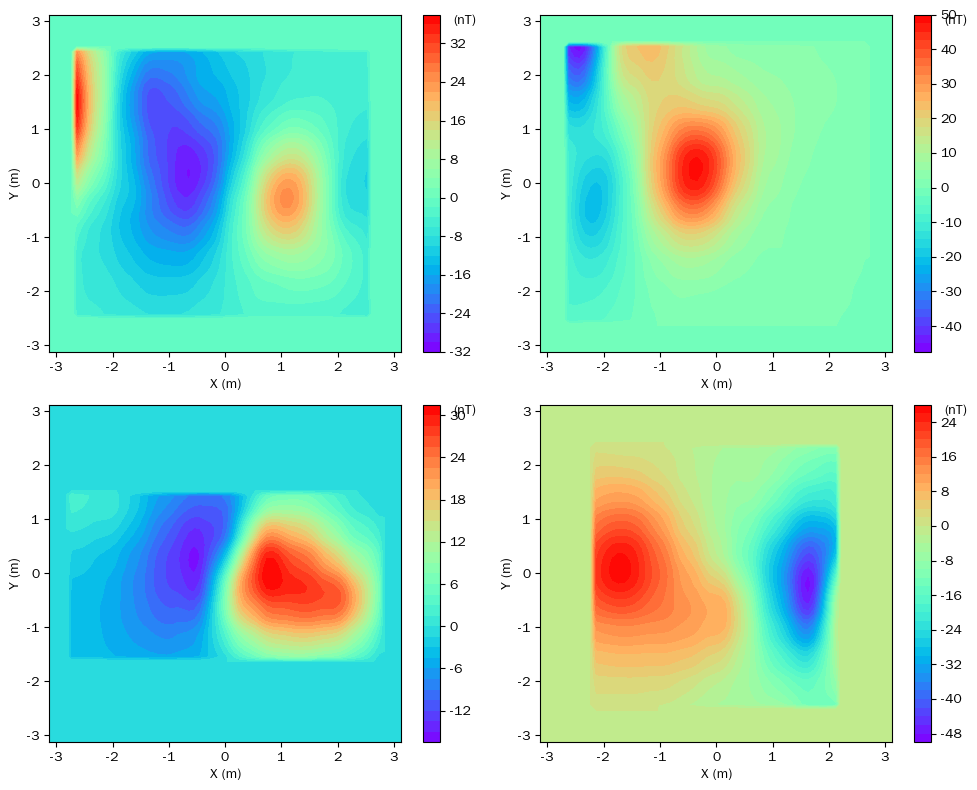

In [38]:
plot_densenet_data(ellipse_data)

## DenseNet

### 导入模型

In [41]:
load_path = '/home/jiajianhao/文档/cnn/my_Magnetic_methods-master/content/my_Densenet_par_9_TL_dipoles.hdf5'

best_model = load_model(load_path, custom_objects={'r2': r2})
best_model.summary()
best_model.compile(optimizer = Adam(learning_rate = 1e-5), 
              loss= MSE,
              metrics= [r2])

2024-06-08 11:37:05.059306: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-06-08 11:37:05.059696: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-06-08 11:37:05.061936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2024-06-08 11:37:05.062277: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:03:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.89GiB deviceMemoryBandwidth: 681.88GiB/s
2024-06-08 11:37:05.062322: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

### 预测

In [42]:
####### Predicting test set ##########

Parameters_predictions_norm = best_model.predict(ellipse_data_img, verbose=0)



Parameters_predictions_norm[:,0] = np.round(Parameters_predictions_norm[:,0], decimals = 1)
Parameters_predictions_norm[:,1] = np.round(Parameters_predictions_norm[:,1], decimals = 1)
#Parameters_predictions_norm[:,2] = np.round(Parameters_predictions_norm[:,2], decimals = 1)


2024-06-08 11:37:15.705393: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-06-08 11:37:15.706181: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499780000 Hz
2024-06-08 11:37:16.469759: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-06-08 11:37:17.448750: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


[        1.6         0.1]


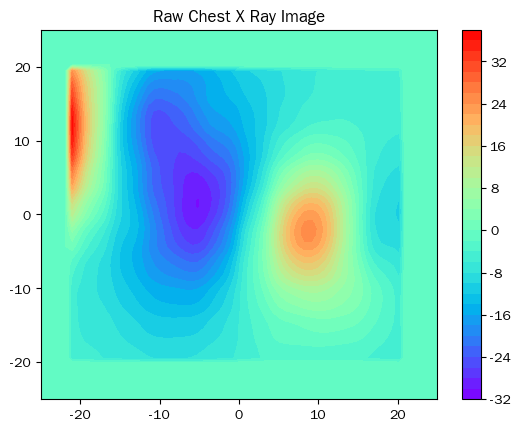

In [43]:
nn = 0

zmax= 64

conversion = (25*2)/zmax
map_lenght = 25

xmin = -map_lenght
xmax = map_lenght
ymin = -map_lenght
ymax = map_lenght

X = np.linspace(xmin, xmax, zmax)
Y = np.linspace(ymin, ymax, zmax)
sample_img = ellipse_data_img[nn,:,:,0]
plt.contourf(X, Y, sample_img, levels = 40, cmap='rainbow')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

# print(test_para[nn])
print(Parameters_predictions_norm[nn])


In [85]:
#Volume_real = np.around(Volume_predictions, decimals=2)
r_real = test_para[:,0]

#Depth_real = np.around(Y_test_params[:,5:10], decimals=2)
Depth_real = test_para[:,1]
#Volume_real = np.around(Volume_predictions, decimals=2)
r_predicted = Parameters_predictions_norm[:,0]

#Depth_real = np.around(Y_test_params[:,5:10], decimals=2)
Depth_predicted = Parameters_predictions_norm[:,1]

/share/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/share/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/share/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/share/anaconda3/envs/tensorflow/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

<Axes: >

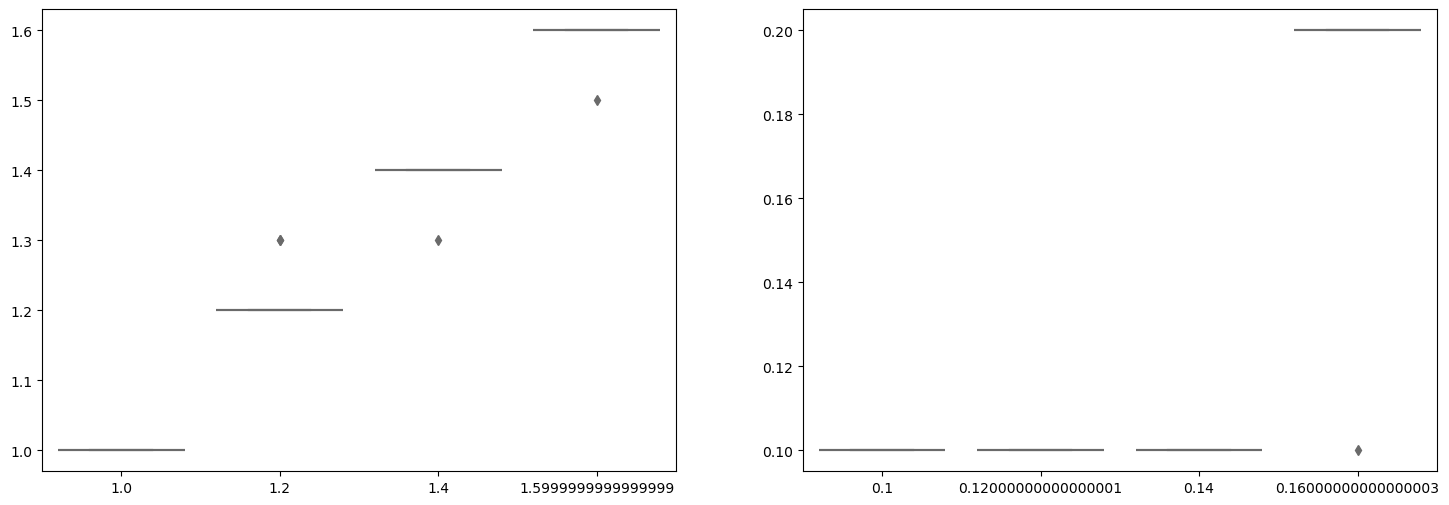

In [86]:
# Box plot visualization 

fig, ax = plt.subplots(1, 2, figsize=(18,6))

sns.set(style="whitegrid")

sns.boxplot(x=r_real[:], y=r_predicted[:], palette="Set3", ax=ax[0])

sns.boxplot(x=Depth_real[:], y=Depth_predicted[:], palette="Set3", ax=ax[1])


## other Net

In [ ]:
models = [
    
]